In [2]:
%matplotlib inline 

import pandas
import pickle
import matplotlib.pyplot as plt 
from sklearn import preprocessing, feature_selection

plt.style.use( 'bmh' ) 

### Feature sets 

In [3]:
# small feature sets, < 100 features per mutant 
feature_sets = [ 
    ( 'feature_sets/rosetta_runs__benchmark.csv', 'RosettaDesign' ), 
    ( 'feature_sets/rosetta_runs__ddg_monomer_high_res.csv', 'Rosetta ddG' ), 
    ( 'feature_sets/foldx_runs__pssm.csv', 'FoldX' ), 
]

### Experimental data 

In [4]:
# load in experimental data 
target_df = pandas.read_csv( '/Users/alex/Documents/bagel-thermal/data_set/targets.csv', index_col=0 )

# the four targets we will be using as training data  
target_names = [ 'kcat', 'km', 'kcatkm', 'tm' ] 

### Feature analysis and scaling 

In [5]:
col_names = ['target', 'feature_set', 'n_features', 'n_features_above_variance_threshold', 'n_samples' ]
feature_summary = []
features = {}

for feature_set, label in feature_sets:

    # read in feature set 
    df = pandas.read_csv( feature_set, index_col=0 ) 
    
    # get only numeric data 
    df = df.select_dtypes([ 'float64' ])
    
    for target in target_names: 
        
        # construct intitial df 
        name = 'target_{}'.format( target )
        tar = target_df[[ name ]]
        
        # join 
        J = tar.join( df ).dropna() 
        
        # break out X, y 
        X = J.ix[:, 1:]
        y = J.ix[:, 0].ravel() 

        # remove features with variance below threshold  
        var = feature_selection.VarianceThreshold( 0.001 )
        X_passed_threshold = var.fit_transform( X )
        support_indices = var.get_support( indices=True )
        X = pandas.DataFrame( X_passed_threshold, columns=X.columns[support_indices] ) 
        
        # scale features 
        scl = preprocessing.RobustScaler()
        scaled_X = scl.fit_transform( X )
        X = pandas.DataFrame( scaled_X, columns=X.columns ) 
    
        # update the features dictionary 
        features.update({ ( target, feature_set ): ( X, y ) })
        
        # print a report 
        result = ( target, feature_set, len(J.columns)-1, len(X.columns), len( J ) ) 
        feature_summary.append( result )
        
        # assess single feature correlations 
        J = X.copy()
        J[ name ] = y
        c = J.corr( method='pearson' )[[ name ]].dropna().drop( name )
        
        # save a sorted table of single-feature correlations 
        c[ 'abs_pearson' ] = c[ name ].map( abs ) 
        c = c.sort_values( by='abs_pearson' ) 
        c.to_csv( 'feature_correlations/{}__{}.csv'.format( target, label ) ) 

# print a nice report dataframe         
pandas.DataFrame( feature_summary, columns=col_names ).sort_values( by='target' )

,target,feature_set,n_features,n_features_above_variance_threshold,n_samples
0,kcat,feature_sets/rosetta_runs__benchmark.csv,59,24,73
4,kcat,feature_sets/rosetta_runs__ddg_monomer_high_re...,18,15,73
8,kcat,feature_sets/foldx_runs__pssm.csv,16,14,75
2,kcatkm,feature_sets/rosetta_runs__benchmark.csv,59,24,76
6,kcatkm,feature_sets/rosetta_runs__ddg_monomer_high_re...,18,15,76
10,kcatkm,feature_sets/foldx_runs__pssm.csv,16,14,78
1,km,feature_sets/rosetta_runs__benchmark.csv,59,24,73
5,km,feature_sets/rosetta_runs__ddg_monomer_high_re...,18,15,73
9,km,feature_sets/foldx_runs__pssm.csv,16,14,75
3,tm,feature_sets/rosetta_runs__benchmark.csv,59,24,76


In [6]:
# write out the scaled features so we can use in ML notebooks 
with open( 'feature_sets/scaled.pkl', 'wb' ) as fn:
    pickle.dump( features, fn )

Here, we will plot features of interest. Each feature of iterest can be defined by the feature name, for now, since all features have unique names. 

In [7]:
for k, v in features.items():
    print( k ) 

('tm', 'feature_sets/foldx_runs__pssm.csv')
('km', 'feature_sets/rosetta_runs__benchmark.csv')
('km', 'feature_sets/foldx_runs__pssm.csv')
('kcatkm', 'feature_sets/rosetta_runs__benchmark.csv')
('kcatkm', 'feature_sets/rosetta_runs__ddg_monomer_high_res.csv')
('tm', 'feature_sets/rosetta_runs__ddg_monomer_high_res.csv')
('kcat', 'feature_sets/rosetta_runs__ddg_monomer_high_res.csv')
('kcat', 'feature_sets/foldx_runs__pssm.csv')
('tm', 'feature_sets/rosetta_runs__benchmark.csv')
('kcatkm', 'feature_sets/foldx_runs__pssm.csv')
('kcat', 'feature_sets/rosetta_runs__benchmark.csv')
('km', 'feature_sets/rosetta_runs__ddg_monomer_high_res.csv')


/usr/local/bin/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


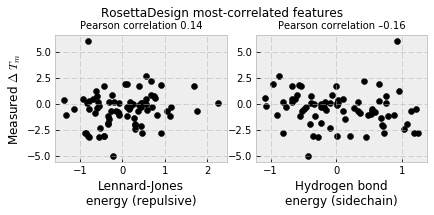

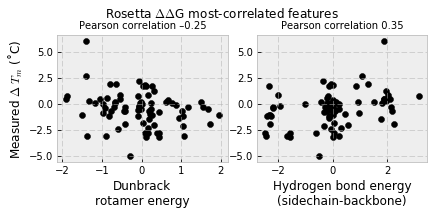

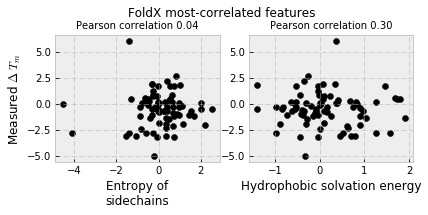

In [14]:
# top 2 features, RosettaDesign 

fig, ax = plt.subplots( nrows=1, ncols=2, figsize=( 6, 3 ) )
X, y = features[ ( 'tm', 'feature_sets/rosetta_runs__benchmark.csv' ) ]

ax[ 0 ].set_title( 'Pearson correlation 0.14', fontsize='medium' ) 
ax[ 0 ].set_ylabel( 'Measured $\Delta \; T_m$' ) 
ax[ 0 ].scatter( X[ 'fa_rep' ], y, color='k' )
ax[ 0 ].set_xlabel( 'Lennard-Jones\nenergy (repulsive)' ) 

ax[ 1 ].set_title( 'Pearson correlation –0.16', fontsize='medium' )
ax[ 1 ].scatter( X[ 'hbond_sc' ], y, color='k' )
ax[ 1 ].set_xlabel( 'Hydrogen bond\nenergy (sidechain)' ) 

fig.suptitle( 'RosettaDesign most-correlated features', fontsize='large' ) 
fig.tight_layout()
fig.subplots_adjust( top=0.85 ) 
fig.show()

# top 2 features, Rosetta ddG 

fig, ax = plt.subplots( nrows=1, ncols=2, figsize=( 6, 3 ) )
X, y = features[ ( 'tm', 'feature_sets/rosetta_runs__ddg_monomer_high_res.csv' ) ]

ax[ 0 ].set_title( 'Pearson correlation –0.25', fontsize='medium' )
ax[ 0 ].set_ylabel( u'Measured $\Delta \; T_m$ (˚C)' ) 
ax[ 0 ].scatter( X[ 'fa_dun' ], y, color='k' )
ax[ 0 ].set_xlabel( 'Dunbrack\nrotamer energy' ) 

ax[ 1 ].set_title( 'Pearson correlation 0.35', fontsize='medium' )
ax[ 1 ].scatter( X[ 'hbond_bb_sc' ], y, color='k' )
ax[ 1 ].set_xlabel( 'Hydrogen bond energy\n(sidechain-backbone)' ) 

fig.suptitle( 'Rosetta $\Delta \Delta$G most-correlated features', fontsize='large' ) 
fig.tight_layout()
fig.subplots_adjust( top=0.85 ) 
fig.show()

# top 2 features, FoldX 

fig, ax = plt.subplots( nrows=1, ncols=2, figsize=( 6, 3 ) )
X, y = features[ ( 'tm', 'feature_sets/foldx_runs__pssm.csv' ) ]

ax[ 0 ].set_title( 'Pearson correlation 0.04', fontsize='medium' )
ax[ 0 ].set_ylabel( 'Measured $\Delta \; T_m$' ) 
ax[ 0 ].scatter( X[ 'entropy sidechain' ], y, color='k' )
ax[ 0 ].set_xlabel( 'Entropy of\nsidechains' ) 

ax[ 1 ].set_title( 'Pearson correlation 0.30', fontsize='medium' )
ax[ 1 ].scatter( X[ 'Solvation Hydrophobic' ], y, color='k' )
ax[ 1 ].set_xlabel( 'Hydrophobic solvation energy' ) 

fig.suptitle( 'FoldX most-correlated features', fontsize='large' ) 
fig.tight_layout()
fig.subplots_adjust( top=0.85 ) 

/usr/local/bin/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


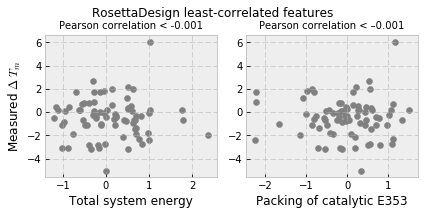

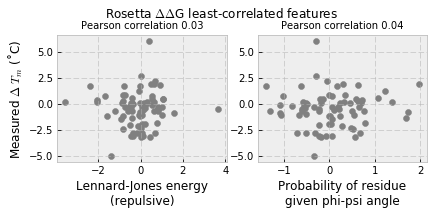

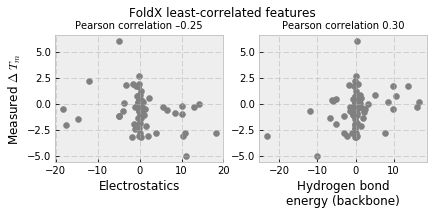

In [13]:
# top 2 features, RosettaDesign 

fig, ax = plt.subplots( nrows=1, ncols=2, figsize=( 6, 3 ) )
X, y = features[ ( 'tm', 'feature_sets/rosetta_runs__benchmark.csv' ) ]

ax[ 0 ].set_title( 'Pearson correlation < -0.001', fontsize='medium' ) 
ax[ 0 ].set_ylabel( 'Measured $\Delta \; T_m$' ) 
ax[ 0 ].scatter( X[ 'total_score' ], y, color='gray' )
ax[ 0 ].set_xlabel( 'Total system energy' ) 

ax[ 1 ].set_title( 'Pearson correlation < –0.001', fontsize='medium' )
ax[ 1 ].scatter( X[ 'SR_3_pstat_pm' ], y, color='gray' )
ax[ 1 ].set_xlabel( 'Packing of catalytic E353' ) 

fig.suptitle( 'RosettaDesign least-correlated features', fontsize='large' ) 
fig.tight_layout()
fig.subplots_adjust( top=0.85 ) 
fig.show()

# top 2 features, Rosetta ddG 

fig, ax = plt.subplots( nrows=1, ncols=2, figsize=( 6, 3 ) )
X, y = features[ ( 'tm', 'feature_sets/rosetta_runs__ddg_monomer_high_res.csv' ) ]

ax[ 0 ].set_title( 'Pearson correlation 0.03', fontsize='medium' )
ax[ 0 ].set_ylabel( u'Measured $\Delta \; T_m$ (˚C)' ) 
ax[ 0 ].scatter( X[ 'fa_rep' ], y, color='gray' )
ax[ 0 ].set_xlabel( 'Lennard-Jones energy\n(repulsive)' ) 

ax[ 1 ].set_title( 'Pearson correlation 0.04', fontsize='medium' )
ax[ 1 ].scatter( X[ 'p_aa_pp' ], y, color='gray' )
ax[ 1 ].set_xlabel( 'Probability of residue\ngiven phi-psi angle' ) 

fig.suptitle( 'Rosetta $\Delta \Delta$G least-correlated features', fontsize='large' ) 
fig.tight_layout()
fig.subplots_adjust( top=0.85 ) 
fig.show()

# top 2 features, FoldX 

fig, ax = plt.subplots( nrows=1, ncols=2, figsize=( 6, 3 ) )
X, y = features[ ( 'tm', 'feature_sets/foldx_runs__pssm.csv' ) ]

ax[ 0 ].set_title( 'Pearson correlation –0.25', fontsize='medium' )
ax[ 0 ].set_ylabel( 'Measured $\Delta \; T_m$' ) 
ax[ 0 ].scatter( X[ 'Electrostatics' ], y, color='gray' )
ax[ 0 ].set_xlabel( 'Electrostatics' ) 

ax[ 1 ].set_title( 'Pearson correlation 0.30', fontsize='medium' )
ax[ 1 ].scatter( X[ 'Backbone Hbond' ], y, color='gray' )
ax[ 1 ].set_xlabel( 'Hydrogen bond\nenergy (backbone)' ) 

fig.suptitle( 'FoldX least-correlated features', fontsize='large' ) 
fig.tight_layout()
fig.subplots_adjust( top=0.85 ) 